In [1]:
import os, sys
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)
print("Project root added to sys.path:", ROOT)

from pathlib import Path
import numpy as np, matplotlib.pyplot as plt
import jax.numpy as jnp
from utils.artifacts_io import latest_run_dir, load_manifest, npz, list_widths
from notebooks.utils_plotting import plot_regression_convergence, print_run_config

Project root added to sys.path: /Users/shreyas/Documents/msc-cs/msc-thesis/code/ntk-experiments


## What Jacot–Gabriel–Hongler tested for NTK convergence in the NTK paper:

- **NTK convergence & (lack of) drift on synthetic data**
  - Inputs lie on the unit circle; visualize the NTK $\Theta(x_0,x)$ at initialization and after training.
  - Compare multiple random initializations across small vs. large widths.
  - Observe variance of the NTK shrinking with width and only mild "inflation" during training that vanishes at large width (i.e., the kernel is effectively constant when wide).

- **Long-time solution matches kernel regression**
  - Tiny least-squares task on a few points on the unit circle.
  - ...

- **Dynamics along NTK principal components (MNIST)**
  - Compute principal components (eigenfunctions) of the NTK.
  - ...

# Reproduction of NTK paper

## Experiment setup (Jacot–Gabriel–Hongler)

- **Probe manifold: unit circle (2D).**  
  Use angles $\gamma \in [-\pi, \pi)$ and define
  $$
    x(\gamma)=\begin{bmatrix}\cos\gamma\\ \sin\gamma\end{bmatrix}\in\mathbb{R}^2.
  $$
  Build a dense grid $\Gamma=\{\gamma_i\}_{i=1}^{N}$ (e.g., $N=360$) and the probe set $X_{\text{circle}}=\{x(\gamma_i)\}$.
  Fix the **anchor** $x_0=(1,0)$.

- **Regression task used for training (separate from the probe).**  
  Draw inputs $x\sim\mathcal N(0,I_2)$ and set the target
  $$
    f^*(x)=x_1x_2.
  $$
  Train with mean-squared error on this Gaussian dataset. The circle is **only** for measuring/plotting the kernel.

- **Model (finite net).**  
  Fully-connected ReLU MLP in **NTK parameterization** with **depth \(L=4\)**
  Compare **two widths** $n\in\{500,\,10000\}$.

- **Training protocol.**  
  Full-batch gradient descent on the Gaussian regression for **200 steps** with **learning rate 1.0**.  
  Repeat for **10 random initializations** per width (to visualize variability across seeds).

- **What is plotted.**  
  The **empirical NTK** profile
  $$
    \gamma \;\mapsto\; \Theta^{(4)}_{\theta_t}\!\big(x_0,\;x(\gamma)\big)
  $$
  measured on the **unit circle** at two times:
  - **$t=0$** (initialization; solid lines),  
  - **$t=200$** (after training; dotted lines).  
  Plot **all seeds** as thin curves for each width.  

- **Expected observations.**  
  Variance across seeds **shrinks** as width increases (kernel concentrates to a deterministic limit).  
  After training, the NTK shows mild **“inflation”** (overall scale increase), which is **much smaller** for the wide network (kernel ~ constant).


In [ ]:
BASE = "../results"; EXP = "ntk_profile_convergence"
RUN = latest_run_dir(BASE, EXP); RUN

PosixPath('/Users/shreyas/Documents/msc-cs/msc-thesis/code/ntk-experiments/results/ntk_profile_convergence/20251031-132510-2ddf69d9')

In [60]:
man = load_manifest(RUN)
geo = npz(RUN, man["probe_geometry"])
gamma, X_circle, x0 = geo["gamma"], geo["X_circle"], geo["x0"]

training_task = npz(RUN, man["training_task"])

theta_inf = npz(RUN, man["analytic_profile"])["theta_inf"]
widths = sorted(list_widths(man))
widths

training_steps = man["meta"]["train_steps"]

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


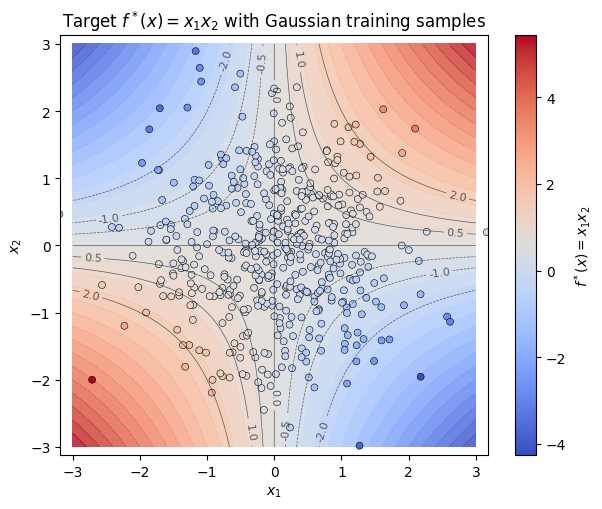

In [61]:
Xtr = training_task["Xtr"]
ytr = training_task["ytr"]

# Visualize f*(x) on a grid, with Gaussian samples overlaid
grid_lim, grid_n = 3.0, 201
xx = jnp.linspace(-grid_lim, grid_lim, grid_n)
yy = jnp.linspace(-grid_lim, grid_lim, grid_n)
XX, YY = jnp.meshgrid(xx, yy, indexing='xy')
ZZ = XX * YY   # f*(x, y) = x*y

plt.figure(figsize=(6.2,5.2))
plt.contourf(np.asarray(XX), np.asarray(YY), np.asarray(ZZ),
             levels=31, cmap='coolwarm', alpha=0.85)
cs = plt.contour(np.asarray(XX), np.asarray(YY), np.asarray(ZZ),
                 levels=[-2,-1,-0.5,0,0.5,1,2], colors='k', linewidths=0.5, alpha=0.6)
plt.clabel(cs, inline=True, fontsize=8, fmt="%.1f")

plt.scatter(np.asarray(Xtr[:,0]), np.asarray(Xtr[:,1]),
            c=np.asarray(ytr), cmap='coolwarm', edgecolor='k', linewidths=0.4, s=25)
plt.colorbar(label=r'$f^*(x)=x_1 x_2$')
plt.title('Target $f^*(x)=x_1x_2$ with Gaussian training samples')
plt.xlabel('$x_1$'); plt.ylabel('$x_2$'); plt.axis('equal')
plt.xlim(-grid_lim, grid_lim); plt.ylim(-grid_lim, grid_lim)
plt.tight_layout(); plt.show()

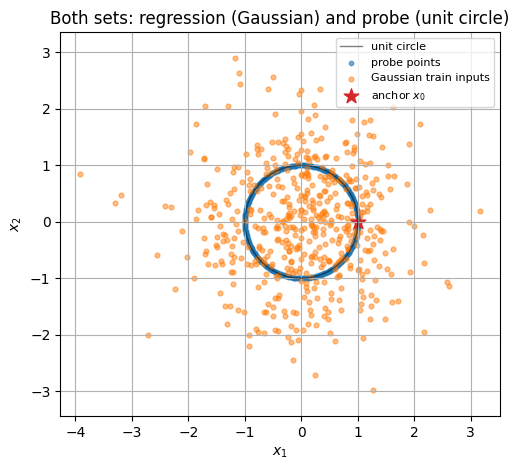

In [62]:
plt.figure(figsize=(5.2, 4.8))
plt.plot(np.cos(gamma), np.sin(gamma), lw=1.0, color='k', alpha=0.5, label='unit circle')
plt.scatter(np.asarray(X_circle[:,0]), np.asarray(X_circle[:,1]),
            s=10, alpha=0.6, label='probe points')
plt.scatter(np.asarray(Xtr[:,0]), np.asarray(Xtr[:,1]),
            s=12, alpha=0.5, label='Gaussian train inputs')
plt.scatter([1.0],[0.0], marker='*', s=120, color='tab:red', label=r'anchor $x_0$')
plt.axis('equal'); plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
plt.title('Both sets: regression (Gaussian) and probe (unit circle)')
plt.legend(fontsize=8); plt.tight_layout()
# plt.savefig("plots/gaussian_vs_circle.png", dpi=300, bbox_inches="tight")
plt.grid()
plt.show()

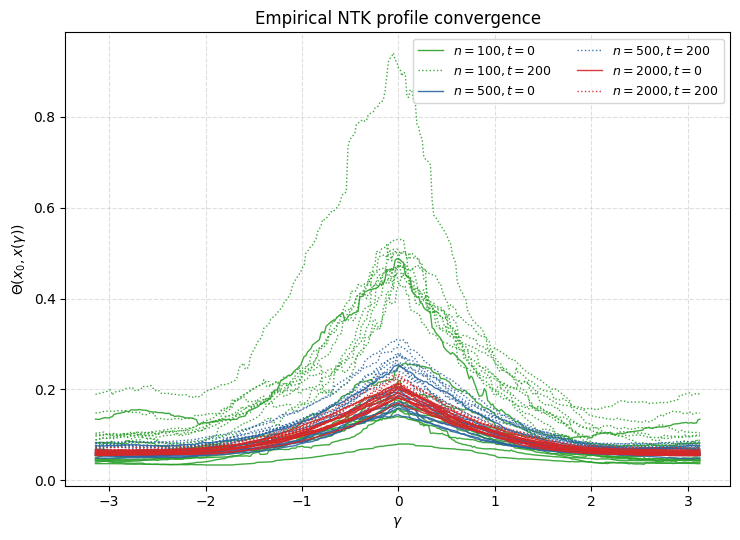

In [63]:
plt.figure(figsize=(7.5,5.5))
color_small, color_medium, color_large = "#2ca02c", "#2c64a0", "#d62728"
cmap = {widths[0]: color_small, widths[len(widths)//2]: color_medium, widths[-1]: color_large}

for w in widths:
    W = npz(RUN, man["profiles"][str(w)])
    c = cmap.get(w, "#888888")
    init_all, post_all = W["init_all"], W["post_all"]
    for k in range(init_all.shape[0]):
        plt.plot(gamma, init_all[k], c=c, lw=1.0, alpha=0.9, label=(fr"$n={w}, t=0$" if k==0 else None))
        plt.plot(gamma, post_all[k], c=c, lw=1.0, alpha=0.9, ls=":", label=(fr"$n={w}, t={training_steps}$" if k==0 else None))

# plt.plot(gamma, theta_inf, "k--", lw=1.6, label="analytic NTK (∞)")
plt.xlabel(r"$\gamma$"); plt.ylabel(r"$\Theta(x_0, x(\gamma))$")
plt.title("Empirical NTK profile convergence"); plt.legend(ncol=2, fontsize=9)
plt.grid(True, ls="--", alpha=0.4); plt.tight_layout()
plt.show()


# Experiment: Do finite-width MLPs converge to the NTK limit?

**Goal.** Replicate classic NTK-style experiments and test whether a trained finite-width ReLU MLP (NTK parameterization) approaches the **infinite-width NTK predictor** as width increases.

---

## Setup

- **Inputs on the unit circle (2D).**  
  For angles $\gamma \in [-\pi, \pi)$,
  $$
    x(\gamma) = \begin{bmatrix}\cos\gamma \\ \sin\gamma\end{bmatrix} \in \mathbb{R}^2.
  $$
  Construct a dense grid $\Gamma = \{\gamma_i\}_{i=1}^N$ and the corresponding dataset $X_{\mathrm{eval}} = \{x(\gamma_i)\}_{i=1}^N$.

- **Targets (two variants).**  
  **(A) Simple baseline (paper-like):** $f^*(x)=x_1x_2$. On the circle this equals $\tfrac{1}{2}\sin(2\gamma)$ (a single low-frequency mode).  
  **(B) Harder mixture (to reveal convergence):**
  $$
    y(\gamma) = \sum_{k\in\mathcal K} a_k\,\sin\!\big(k\,\gamma+\phi_k\big) + \varepsilon,\quad
    \varepsilon \sim \mathcal N(0,\sigma^2),
  $$
  with $\mathcal K$ including higher frequencies (e.g., $\{2,4,7,11,16,23,32\}$), mildly decaying amplitudes $a_k$, and random phases $\phi_k \sim \mathrm{Unif}[0,2\pi)$.  
  *Idea was to (Use (A) for a sanity check; use (B) to better see finite-width $\to$ NTK convergence.)*

- **Train/Test split on the circle.**  
  Select a **small, random** training subset $X_T=\{x(\gamma_{i_j})\}_{j=1}^{M}$ from $X_{\mathrm{eval}}$ (e.g., $M \in \{32, 64, 128, 256\}$).  
  Targets are $y_T = \{y(\gamma_{i_j})\}$.  
  Evaluate on the full grid $X_{\mathrm{eval}}$.  

- **Model (finite net).**  
  Fully-connected ReLU MLP in **NTK parameterization**, depth $L$ (e.g., $L=2$ or $L=4$; keep this fixed), width $n$ swept over
  $\{64,128,256,512,1024,2048,4096,8192\}$.  
  Include **biases**.  
  **Loss:** MSE. **Optimizer:** full-batch GD/SGD with a small learning rate (e.g., $10^{-2}$) to approximate gradient flow; train to near-zero train MSE.

- **Analytic NTK (infinite width).**  
  Build the deterministic limit kernel with  
  `kernel_fn(X, X', get='ntk')` using the **same architecture/activation/parameterization and init hyperparameters**.  
  **NTK predictor (kernel ridge):**
  $$
    \alpha=(K_{TT}+\lambda I)^{-1} y_T,\qquad
    \hat y_{\infty}(X)=K_{XT}\,\alpha,
  $$
  with small $\lambda$ (e.g., $10^{-6}$). $K_{TT}$ is the NTK gram matrix between the training points, $K_{XT}$ is the NTK gram matrix between the test points and the training points. 

- **Across-seed robustness.**  
  For each width, repeat training over multiple random initializations (e.g., 10 seeds); summarize by median and percentile bands.  
  *(Seeds affect finite nets; the analytic NTK predictor does not.)*

---

## Procedure

1. **Generate unit-circle grid** $\Gamma$ and $X_{\mathrm{eval}}$.  
2. **Choose a target**: start with **(A) simple baseline**, then **(B) harder mixture** to see convergence.  
3. **Sample a small random training set** $X_T \subset X_{\mathrm{eval}}$; form $y_T$.  
4. **Compute the analytic NTK predictor** once: $K_{TT}, K_{XT} \to \hat y_{\infty}(X_{\mathrm{eval}})$.  
5. **For each width \(n\):** initialize, train the finite net on $(X_T,y_T)$ with full-batch GD to small MSE; obtain $\hat y_n(X_{\mathrm{eval}})$.  
6. **Compare in function space:**  
   - Overlay $\hat y_n(\gamma)$ and $\hat y_{\infty}(\gamma)$ on $\gamma\in[-\pi,\pi)$.  
   - Record
     $$
       \mathrm{RelErr}(n)=\frac{\|\hat y_n-\hat y_{\infty}\|_2}{\|\hat y_{\infty}\|_2}.
     $$
---

## Expected outcomes & notes

- **Convergence:** As width $n$ increases, $\hat y_n \to \hat y_{\infty}$ and RelErr$(n)$ decreases.
- **Task difficulty:** The simple baseline $x_1x_2=\sin(\gamma)\cos(\gamma)=\tfrac12\sin(2\gamma)$ is **low-frequency** and easy; many widths will already match the NTK closely. The **harder mixture** (with higher modes and fewer train points) should make differences visible at small widths and highlights convergence as $n\uparrow$.  
- **Optimization:** Full-batch GD best mirrors NTK gradient flow.


In [65]:
BASE = "../results"; EXP = "ntk_regression_simple"
RUN = latest_run_dir(BASE, EXP)

In [66]:
print_run_config(RUN)

─────────────────────────────────────────
Run: /Users/shreyas/Documents/msc-cs/msc-thesis/code/ntk-experiments/results/ntk_regression_simple/20251031-141949-2eef824c
Task: simple
Dataset file: data_simple.npz
 
Data:
  n_eval:   720
  M_train:  64
 
Model:
  depth_hidden: 1
  b_std:        0.1
 
Training:
  steps: 30000
  lr:    0.01
  seeds: 10
 
Sweep:
  widths: [512, 1024, 2048, 4096, 8192]
 
Analysis:
  reg (config): 1e-06
  reg (artifact): 1e-06
─────────────────────────────────────────


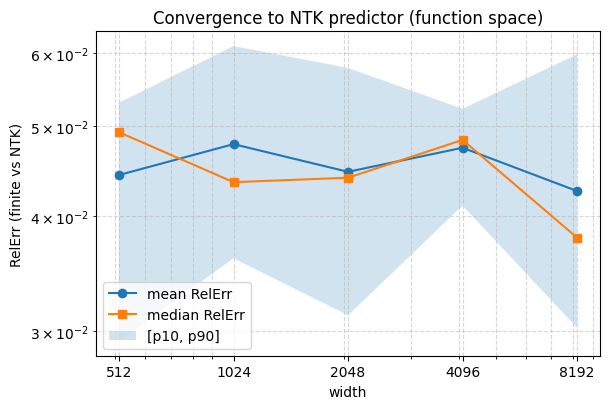

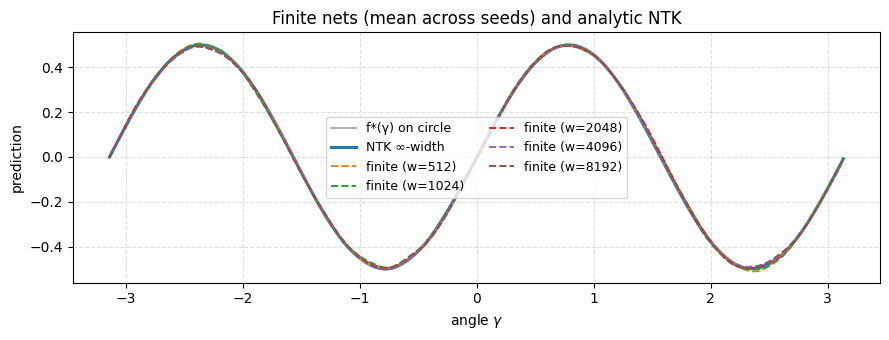

In [67]:
res = plot_regression_convergence(RUN, show_predictions=True)

## Using a more complex dataset

In [68]:
BASE = "../results"; EXP = "ntk_regression_fourier_complex"
RUN = latest_run_dir(BASE, EXP)

In [69]:
print_run_config(RUN)

─────────────────────────────────────────
Run: /Users/shreyas/Documents/msc-cs/msc-thesis/code/ntk-experiments/results/ntk_regression_fourier_complex/20251031-144657-35f6ae45
Task: fourier
Dataset file: data_fourier.npz
 
Data:
  n_eval:   720
  M_train:  256
Fourier target:
  Ks:     [2.0, 4.0, 7.0, 11.0, 16.0, 23.0, 32.0]
  amps:   [0.8999999761581421, 0.699999988079071, 0.550000011920929, 0.44999998807907104, 0.3499999940395355, 0.2800000011920929, 0.2199999988079071]
  phases: [0.0, 1.5707963705062866, 1.2000000476837158, 2.0, 0.9419999718666077, 4.5, 5.800000190734863]
 
Model:
  depth_hidden: 1
  b_std:        0.1
 
Training:
  steps: 30000
  lr:    0.01
  seeds: 10
 
Sweep:
  widths: [512, 1024, 2048, 4096, 8192, 16384]
 
Analysis:
  reg (config): 1e-06
  reg (artifact): 1e-06
─────────────────────────────────────────


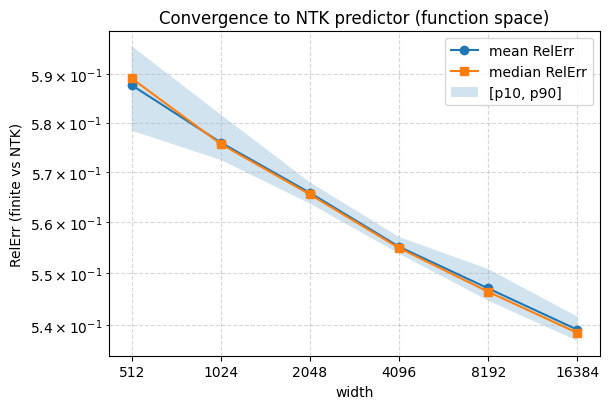

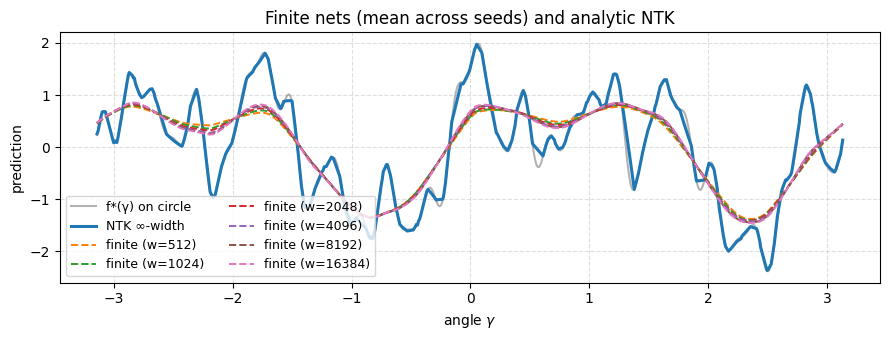

In [70]:
res = plot_regression_convergence(RUN, show_predictions=True, use_logx=False)

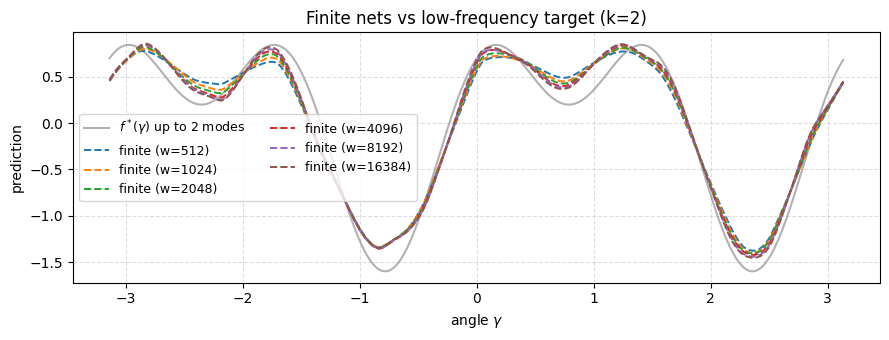

In [71]:
from core.data import make_fourier_target, f_star_gamma_partial

dataset = npz(RUN, load_manifest(RUN)["dataset"])

Ks, amps, phases = dataset["Ks"], dataset["amps"], dataset["phases"]
spec = make_fourier_target(Ks, amps, phases)

gamma_eval = res["gamma_eval"]
widths = res["widths"]
predictions = res["predictions"]

k = 2   # e.g. plot partial target with first k frequencies

plt.figure(figsize=(9, 3.5))
plt.plot(
    np.asarray(gamma_eval),
    f_star_gamma_partial(gamma_eval, spec, k),
    color='gray', alpha=0.6,
    label=fr"$f^*(\gamma)$ up to {k} modes"
)

for w in widths:
    s = predictions[w]
    plt.plot(
        np.asarray(gamma_eval),
        s["pred_mean"],
        '--', lw=1.4,
        label=f'finite (w={w})'
    )

plt.xlabel(r'angle $\gamma$')
plt.ylabel('prediction')
plt.title(fr'Finite nets vs low-frequency target (k={k})')
plt.legend(ncol=2, fontsize=9, loc="best")
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Using lower widths, higher LR, more training steps (gradient descent steps)

In [48]:
BASE = "../results"; EXP = "ntk_regression_fourier_low_width_high_lr"
RUN = latest_run_dir(BASE, EXP)

In [49]:
print_run_config(RUN)

─────────────────────────────────────────
Run: /Users/shreyas/Documents/msc-cs/msc-thesis/code/ntk-experiments/results/ntk_regression_fourier_low_width_high_lr/20251031-185826-e6ff4f26
Task: fourier
Dataset file: data_fourier.npz
 
Data:
  n_eval:   720
  M_train:  256
Fourier target:
  Ks:     [2.0, 4.0, 7.0, 11.0, 16.0, 23.0, 32.0]
  amps:   [0.8999999761581421, 0.699999988079071, 0.550000011920929, 0.44999998807907104, 0.3499999940395355, 0.2800000011920929, 0.2199999988079071]
  phases: [0.0, 1.5707963705062866, 1.2000000476837158, 2.0, 0.9419999718666077, 4.5, 5.800000190734863]
 
Model:
  depth_hidden: 1
  b_std:        0.1
 
Training:
  steps: 100000
  lr:    1.0
  seeds: 10
 
Sweep:
  widths: [2, 4, 6, 8, 10, 100, 1000, 10000, 15000]
 
Analysis:
  reg (config): 1e-06
  reg (artifact): 1e-06
─────────────────────────────────────────


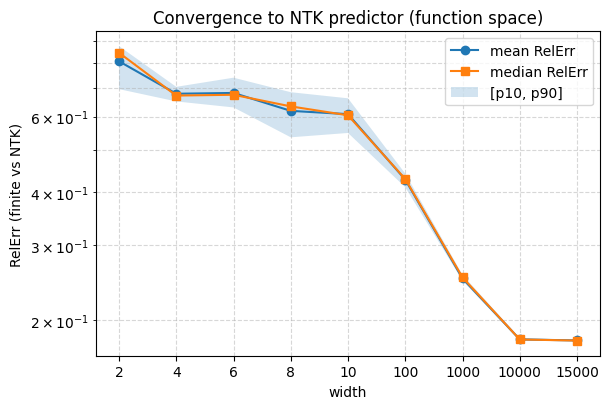

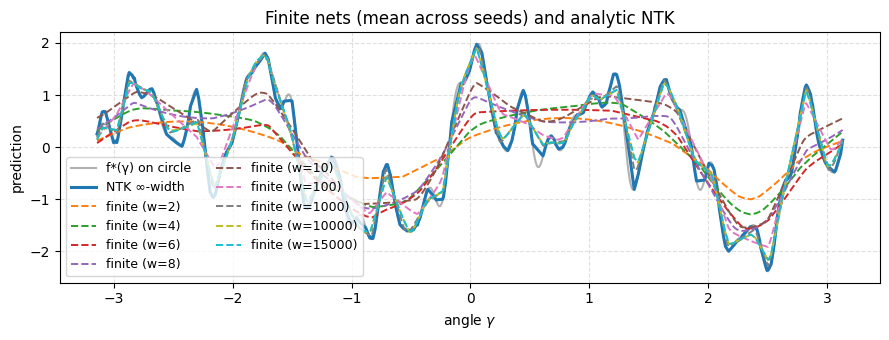

In [74]:
res = plot_regression_convergence(RUN, show_predictions=True, use_logx=False)

# Trying to get 10, 100, 1000 widths to converge

In [50]:
BASE = "../results"; EXP = "ntk_regression_fourier_complex_longer_time"
RUN = latest_run_dir(BASE, EXP)

In [51]:
print_run_config(RUN)

─────────────────────────────────────────
Run: /Users/shreyas/Documents/msc-cs/msc-thesis/code/ntk-experiments/results/ntk_regression_fourier_complex_longer_time/20251115-233259-0adc6960
Task: fourier
Dataset file: data_fourier.npz
 
Data:
  n_eval:   720
  M_train:  256
Fourier target:
  Ks:     [2.0, 4.0, 7.0, 11.0, 16.0, 23.0, 32.0]
  amps:   [0.8999999761581421, 0.699999988079071, 0.550000011920929, 0.44999998807907104, 0.3499999940395355, 0.2800000011920929, 0.2199999988079071]
  phases: [0.0, 1.5707963705062866, 1.2000000476837158, 2.0, 0.9419999718666077, 4.5, 5.800000190734863]
 
Model:
  depth_hidden: 1
  b_std:        0.1
 
Training:
  steps: 1000000
  lr:    3
  seeds: 10
 
Sweep:
  widths: [45, 100]
 
Analysis:
  reg (config): 1e-06
  reg (artifact): 1e-06
─────────────────────────────────────────


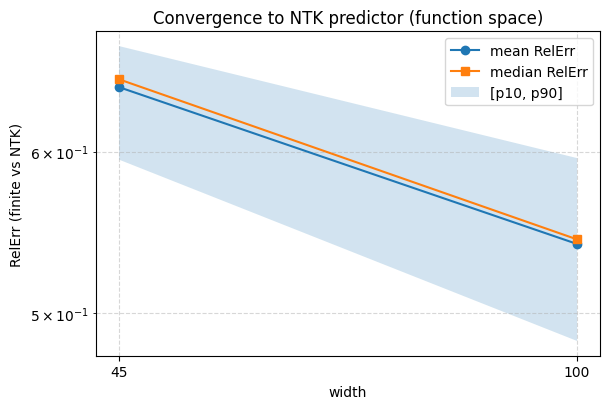

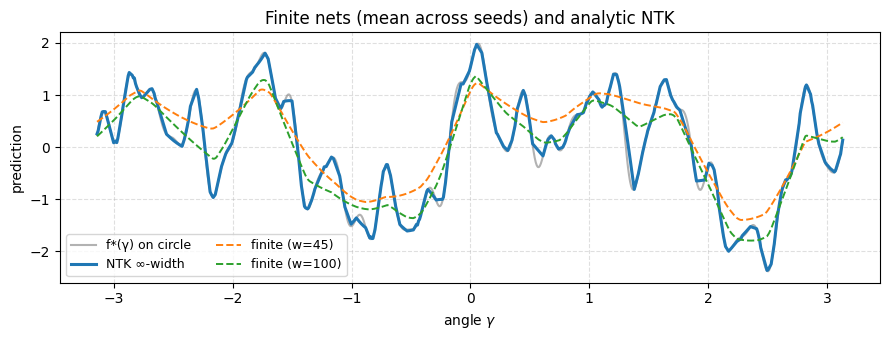

In [52]:
res = plot_regression_convergence(RUN, show_predictions=True, use_logx=False)

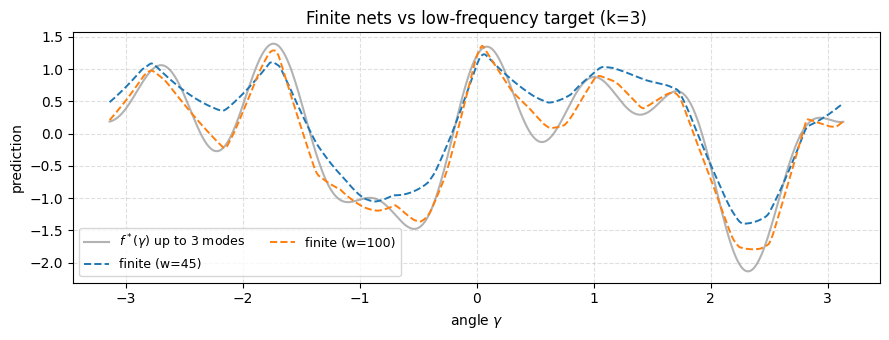

In [54]:
from core.data import make_fourier_target, f_star_gamma_partial

dataset = npz(RUN, load_manifest(RUN)["dataset"])

Ks, amps, phases = dataset["Ks"], dataset["amps"], dataset["phases"]
spec = make_fourier_target(Ks, amps, phases)

gamma_eval = res["gamma_eval"]
widths = res["widths"]
predictions = res["predictions"]

k = 3   # e.g. plot partial target with first k frequencies

plt.figure(figsize=(9, 3.5))
plt.plot(
    np.asarray(gamma_eval),
    f_star_gamma_partial(gamma_eval, spec, k),
    color='gray', alpha=0.6,
    label=fr"$f^*(\gamma)$ up to {k} modes"
)

for w in widths:
    s = predictions[w]
    plt.plot(
        np.asarray(gamma_eval),
        s["pred_mean"],
        '--', lw=1.4,
        label=f'finite (w={w})'
    )

plt.xlabel(r'angle $\gamma$')
plt.ylabel('prediction')
plt.title(fr'Finite nets vs low-frequency target (k={k})')
plt.legend(ncol=2, fontsize=9, loc="best")
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

# $\beta$ sweep

In [ ]:
BASE = "../results"; EXP = "ntk_profile_beta_sweep"
RUN = latest_run_dir(BASE, EXP)

In [6]:
man = load_manifest(RUN)
man["meta"]

{'b_std': 0.1,
 'train_steps': 200,
 'lr': 1.0,
 'seeds': 5,
 'widths': [64, 128, 256, 512, 1024],
 'depths': [1, 2, 4, 8],
 'probe_m': 128,
 'n_update_samples': 64,
 'input_dim': 2}

In [10]:
probe = npz(RUN, man["probe_geometry"])
gamma = probe["gamma"]
theta_inf = npz(RUN, man["analytic_profile"])["theta_inf"]
training_steps = man["meta"]["train_steps"]

# --- Collect all available (width, depth) pairs
keys = [k.split("-") for k in man["profiles"].keys()]
widths_all = sorted({int(w) for w, _ in keys})
depths_all = sorted({int(d) for _, d in keys})

print("Depths found:", depths_all)
print("Widths found:", widths_all)

Depths found: [1, 2, 4, 8]
Widths found: [64, 128, 256, 512, 1024]


In [20]:
def build_beta_index(RUN, man, round_to=4):
    beta_index = {}
    for key, relpath in man["profiles"].items():  # keys like "512-1"
        data = npz(RUN, relpath)
        beta = float(data["beta"])
        bkey = round(beta, round_to)
        width = int(data["width"])
        depth = int(data["depth"])
        beta_index.setdefault(bkey, []).append(
            dict(width=width, depth=depth, path=relpath)
        )
    # sort entries within each beta by width
    for b in beta_index:
        beta_index[b] = sorted(beta_index[b], key=lambda d: d["width"])
    return dict(sorted(beta_index.items(), key=lambda kv: kv[0]))


Betas found: [0.001, 0.002, 0.0039, 0.0078, 0.0156, 0.0312, 0.0625, 0.125]
Betas selected: [0.001, 0.0625, 0.125]
beta: 0.001 = 1/1024
beta: 0.0625 = 8/128
beta: 0.125 = 8/64


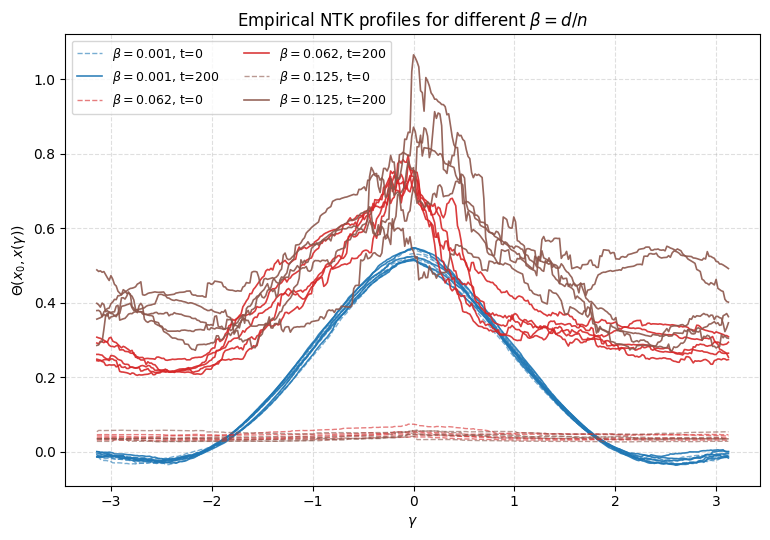

In [40]:
from matplotlib.colors import ListedColormap

beta_index = build_beta_index(RUN, man, round_to=4)

betas = sorted(beta_index.keys(), key=float)
print("Betas found:", betas)

betas = [betas[0]]+betas[-2:]
print("Betas selected:", betas)

# --- custom color gradient (blue → green → orange → red → purple)
colors = ListedColormap([
    "#1f77b4", "#2ca02c", "#ff7f0e", "#d62728", "#9467bd", "#8c564b"
])
n_colors = len(betas)
palette = [colors(i / max(1, n_colors - 1)) for i in range(n_colors)]

# --- prepare figure
plt.figure(figsize=(7.8, 5.5))

for color, beta_key in zip(palette, betas):
    entries = beta_index[beta_key]
    e = max(entries, key=lambda item: item["width"])
    print(f"beta: {beta_key} = {e['depth']}/{e['width']}")
    w, d = e["width"], e["depth"]
    W = npz(RUN, e["path"])
    init_all, post_all = W["init_all"], W["post_all"]

    # ---- Initialization (t=0): dashed
    for k in range(init_all.shape[0]):
        plt.plot(
            gamma,
            init_all[k],
            lw=1.0,
            alpha=0.6,
            color=color,
            ls="--",
            label=fr"$\beta={float(beta_key):.3f}$, t=0" if k == 0 else None,
        )

    # ---- Post-training (t=T): solid
    for k in range(post_all.shape[0]):
        plt.plot(
            gamma,
            post_all[k],
            lw=1.2,
            alpha=0.9,
            color=color,
            label=fr"$\beta={float(beta_key):.3f}$, t={training_steps}" if k == 0 else None,
        )

# --- optional: analytic NTK reference
# plt.plot(gamma, theta_inf, "k--", lw=1.6, label="analytic NTK (∞ width)")

plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\Theta(x_0, x(\gamma))$")
plt.title(r"Empirical NTK profiles for different $\beta = d/n$")
plt.legend(ncol=2, fontsize=9, frameon=True)
plt.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [32]:
widths, depths, betas, diag_S2, dK_rel_mean = [], [], [], [], []

for key, path in man["profiles"].items():
    data = npz(RUN, path)
    meta = data["beta"]  # scalar saved in each file
    widths.append(int(data["width"]))
    depths.append(int(data["depth"]))
    betas.append(float(meta))
    diag_S2.append(float(data["diag_S2"]))
    dK_rel_mean.append(np.mean(data["deltaK_rel_all"]))
    
widths, depths, betas = np.array(widths), np.array(depths), np.array(betas)
diag_S2, dK_rel_mean = np.array(diag_S2), np.array(dK_rel_mean)

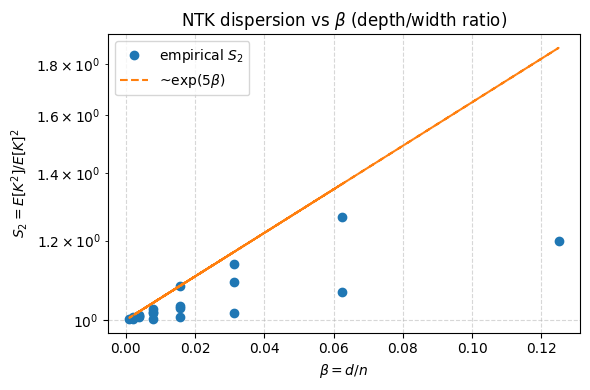

In [36]:
plt.figure(figsize=(6,4))
plt.semilogy(betas, diag_S2, "o", label="empirical $S_2$")
plt.semilogy(betas, np.exp(5*betas), "--", label="~exp(5$\\beta$)")
plt.xlabel(r"$\beta = d/n$")
plt.ylabel(r"$S_2 = E[K^2]/E[K]^2$")
plt.title("NTK dispersion vs $\\beta$ (depth/width ratio)")
plt.grid(True, ls="--", alpha=0.5)
plt.legend(); plt.tight_layout(); plt.show()


# $\beta$ sweep with fixed width 256

In [30]:
BASE = "../results"; EXP = "ntk_profile_beta_fixed_width"
RUN = latest_run_dir(BASE, EXP)

In [31]:
man = load_manifest(RUN)
man["meta"]

{'b_std': 0.1,
 'train_steps': 200,
 'lr': 1.0,
 'seeds': 10,
 'widths': [256],
 'depths': [1, 4, 16, 64, 128, 256],
 'probe_m': 128,
 'n_update_samples': 32,
 'input_dim': 2}

In [44]:
probe = npz(RUN, man["probe_geometry"])
gamma = probe["gamma"]
theta_inf = npz(RUN, man["analytic_profile"])["theta_inf"]
training_steps = man["meta"]["train_steps"]

# --- Collect all available (width, depth) pairs
keys = [k.split("-") for k in man["profiles"].keys()]
widths_all = sorted({int(w) for w, _ in keys})
depths_all = sorted({int(d) for _, d in keys})

print("Depths found:", depths_all)
print("Widths found:", widths_all)

Depths found: [1, 4, 16, 64, 128, 256]
Widths found: [256]


Betas found: [0.0039, 0.0156, 0.0625, 0.25, 0.5, 1.0]
{'width': 256, 'depth': 4, 'path': 'profiles/width_256_depth_4.npz'}
{'width': 256, 'depth': 16, 'path': 'profiles/width_256_depth_16.npz'}
{'width': 256, 'depth': 64, 'path': 'profiles/width_256_depth_64.npz'}
{'width': 256, 'depth': 128, 'path': 'profiles/width_256_depth_128.npz'}
{'width': 256, 'depth': 256, 'path': 'profiles/width_256_depth_256.npz'}


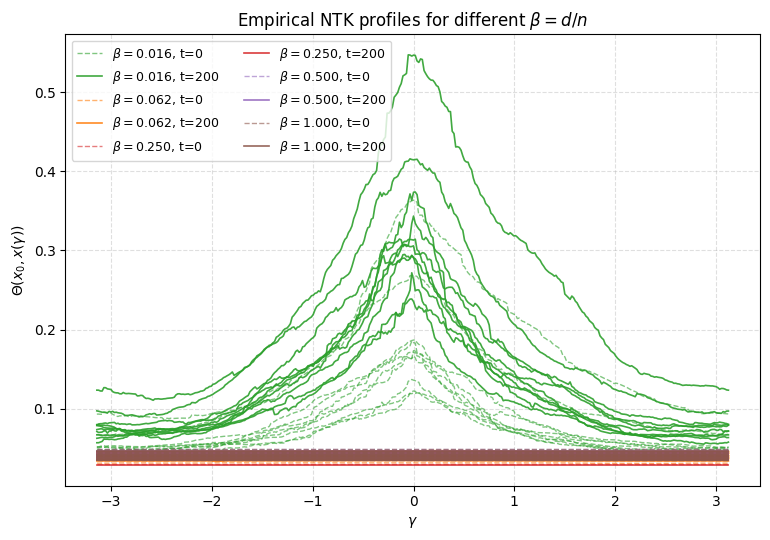

In [54]:
from matplotlib.colors import ListedColormap

beta_index = build_beta_index(RUN, man, round_to=4)

betas = sorted(beta_index.keys(), key=float)
print("Betas found:", betas)

# --- custom color gradient (blue → green → orange → red → purple)
colors = ListedColormap([
    "#1f77b4", "#2ca02c", "#ff7f0e", "#d62728", "#9467bd", "#8c564b"
])
n_colors = len(betas)
palette = [colors(i / max(1, n_colors - 1)) for i in range(n_colors)]

# --- prepare figure
plt.figure(figsize=(7.8, 5.5))

for color, beta_key in zip(palette[-5:], betas[-5:]):
    entry = beta_index[beta_key][0]
    print(entry)
    W = npz(RUN, entry["path"])
    init_all, post_all = W["init_all"], W["post_all"]

    # ---- Initialization (t=0): dashed
    for k in range(init_all.shape[0]):
        plt.plot(
            gamma,
            init_all[k],
            lw=1.0,
            alpha=0.6,
            color=color,
            ls="--",
            label=fr"$\beta={float(beta_key):.3f}$, t=0" if k == 0 else None,
        )

    # ---- Post-training (t=T): solid
    for k in range(post_all.shape[0]):
        plt.plot(
            gamma,
            post_all[k],
            lw=1.2,
            alpha=0.9,
            color=color,
            label=fr"$\beta={float(beta_key):.3f}$, t={training_steps}" if k == 0 else None,
        )

# --- optional: analytic NTK reference
# plt.plot(gamma, theta_inf, "k--", lw=1.6, label="analytic NTK (∞ width)")

plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\Theta(x_0, x(\gamma))$")
plt.title(r"Empirical NTK profiles for different $\beta = d/n$")
plt.legend(ncol=2, fontsize=9, frameon=True)
plt.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [55]:
widths, depths, betas, diag_S2, dK_rel_mean = [], [], [], [], []

for key, path in man["profiles"].items():
    data = npz(RUN, path)
    meta = data["beta"]  # scalar saved in each file
    widths.append(int(data["width"]))
    depths.append(int(data["depth"]))
    betas.append(float(meta))
    diag_S2.append(float(data["diag_S2"]))
    dK_rel_mean.append(np.mean(data["deltaK_rel_all"]))
    
widths, depths, betas = np.array(widths), np.array(depths), np.array(betas)
diag_S2, dK_rel_mean = np.array(diag_S2), np.array(dK_rel_mean)

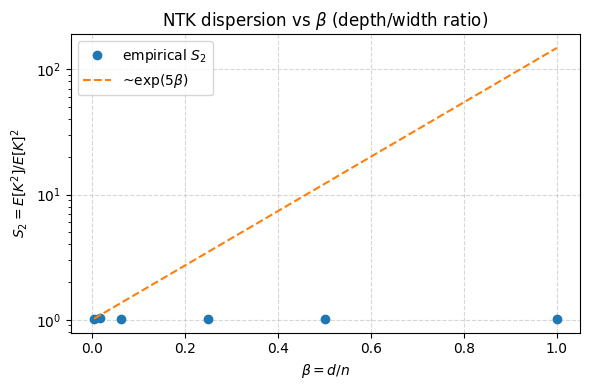

In [56]:
plt.figure(figsize=(6,4))
plt.semilogy(betas, diag_S2, "o", label="empirical $S_2$")
plt.semilogy(betas, np.exp(5*betas), "--", label="~exp(5$\\beta$)")
plt.xlabel(r"$\beta = d/n$")
plt.ylabel(r"$S_2 = E[K^2]/E[K]^2$")
plt.title("NTK dispersion vs $\\beta$ (depth/width ratio)")
plt.grid(True, ls="--", alpha=0.5)
plt.legend(); plt.tight_layout(); plt.show()


In [57]:
print(diag_S2)

[1.01375103 1.03324664 1.01605141 1.01221359 1.01776373 1.01023245]


In [29]:
from core.analysis import empirical_ntk_diag
from core.model import build_mlp
from core.data import make_probe_circle
import jax

gamma, X_probe, _ = make_probe_circle(5)  # small M
init_fn, apply_fn, _ = build_mlp(width=100, b_std=0.0, depth_hidden=5)

_, params0 = init_fn(jax.random.PRNGKey(0), (1,2))
diag_vals = empirical_ntk_diag(apply_fn, params0, X_probe)

print("X_probe shape:", X_probe.shape)
print("diag_vals shape:", diag_vals.shape)
print("diag_vals:", diag_vals)

X_probe shape: (5, 2)
diag_vals shape: (5,)
diag_vals: [0.19880727 0.136996   0.20689425 0.14854442 0.09350324]


In [33]:
man

{'probe_geometry': 'probe_geometry.npz',
 'training_task': 'training_task.npz',
 'analytic_profile': 'analytic_profile.npz',
 'profiles': {'256-1': 'profiles/width_256_depth_1.npz',
  '256-4': 'profiles/width_256_depth_4.npz',
  '256-16': 'profiles/width_256_depth_16.npz',
  '256-64': 'profiles/width_256_depth_64.npz',
  '256-128': 'profiles/width_256_depth_128.npz',
  '256-256': 'profiles/width_256_depth_256.npz'},
 'meta': {'b_std': 0.1,
  'train_steps': 200,
  'lr': 1.0,
  'seeds': 10,
  'widths': [256],
  'depths': [1, 4, 16, 64, 128, 256],
  'probe_m': 128,
  'n_update_samples': 32,
  'input_dim': 2},
 'runtime_sec': 2278.02}

In [35]:
data = npz(RUN, man["profiles"]["256-256"])
diag_all = data["diag_init_all"]   # your saved diag_stack

print(diag_all.shape)              # expect (n_seeds, probe_m)

mu = diag_all.mean(axis=0)
m2 = (diag_all**2).mean(axis=0)
S2 = m2 / (mu**2)

print("mu (first few):", mu[:5])
print("S2 (first few):", S2[:5])
print("S2 mean:", S2.mean())
print("saved S2:", data["diag_S2"])

(10, 128)
mu (first few): [0.04146937 0.04146937 0.04146937 0.04146937 0.04146937]
S2 (first few): [1.0102329 1.010233  1.010233  1.0102329 1.010233 ]
S2 mean: 1.0102329
saved S2: 1.0102324485778809


In [ ]:
BASE = "../results"; EXP = "ntk_beta_dispersion"
RUN = latest_run_dir(BASE, EXP)

In [ ]:
man = load_manifest(run)
man["meta"]

{'widths': [256, 512, 1024],
 'depths': [4, 8, 16, 32, 64],
 'seeds': 20,
 'b_std': 0.0,
 'parameterization': 'standard',
 'probe_m': 64,
 'n_profile': 128}

In [43]:
man

{'probe_geometry': 'probe_geometry.npz',
 'results': {'256-4': 'results/width_256_depth_4.npz',
  '256-8': 'results/width_256_depth_8.npz',
  '256-16': 'results/width_256_depth_16.npz',
  '256-32': 'results/width_256_depth_32.npz',
  '256-64': 'results/width_256_depth_64.npz',
  '512-4': 'results/width_512_depth_4.npz',
  '512-8': 'results/width_512_depth_8.npz',
  '512-16': 'results/width_512_depth_16.npz',
  '512-32': 'results/width_512_depth_32.npz',
  '512-64': 'results/width_512_depth_64.npz',
  '1024-4': 'results/width_1024_depth_4.npz',
  '1024-8': 'results/width_1024_depth_8.npz',
  '1024-16': 'results/width_1024_depth_16.npz',
  '1024-32': 'results/width_1024_depth_32.npz',
  '1024-64': 'results/width_1024_depth_64.npz'},
 'meta': {'widths': [256, 512, 1024],
  'depths': [4, 8, 16, 32, 64],
  'seeds': 20,
  'b_std': 0.0,
  'parameterization': 'standard',
  'probe_m': 64,
  'n_profile': 128},
 'runtime_sec': 3740.3}

In [ ]:
probe = npz(RUN, man["probe_geometry"])
gamma = probe["gamma"]

# --- Collect all available (width, depth) pairs
widths_all = man["meta"]["widths"]
depths_all = man["meta"]["depths"]

print("Depths found:", depths_all)
print("Widths found:", widths_all)

Depths found: [4, 8, 16, 32, 64]
Widths found: [256, 512, 1024]


In [44]:
results = man["results"]

betas = []
S2_vals = []
pairs = []   # store (width, depth)

for key, relpath in results.items():
    # parse "width-depth"
    w_str, d_str = key.split("-")
    w = int(w_str)
    d = int(d_str)
    beta = d / w

    # load npz file
    data = npz(RUN, relpath)
    S2 = float(data["diag_S2"])

    pairs.append((w, d))
    betas.append(beta)
    S2_vals.append(S2)

betas = np.array(betas)
S2_vals = np.array(S2_vals)
pairs = np.array(pairs)

In [45]:
order = np.argsort(betas)
betas = betas[order]
S2_vals = S2_vals[order]
pairs = pairs[order]

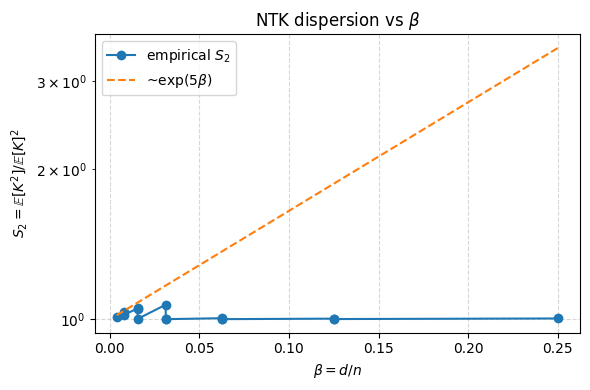

In [47]:
plt.figure(figsize=(6,4))
plt.semilogy(betas, S2_vals, "o-", label="empirical $S_2$")
plt.semilogy(betas, np.exp(5*betas), "--", label="~exp(5$\\beta$)")
plt.xlabel(r"$\beta = d/n$")
plt.ylabel(r"$S_2 = \mathbb{E}[K^2]/\mathbb{E}[K]^2$")
plt.title("NTK dispersion vs $\\beta$")
plt.grid(True, ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
